In [ ]:
!pip install peft
!pip install flash_attn
!pip install bitsandbytes
!pip install tiktoken
!pip install verovio

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("/kaggle/input/amazon-challenge/student_resource 3/src")

In [3]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from constants import entity_unit_map, allowed_units
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_in_model, dispatch_model

In [4]:
inference_img_path = "/kaggle/input/train-csv-files/test_images_data/home/taruntejaneurips23/student_resource_3/student_resource/dataset/test_images"
inference_data_path = "/kaggle/input/images-path-and-text/test_path_text.csv"

In [5]:
inference_data = pd.read_csv(inference_data_path)

In [6]:
inference_data.head()

,index,image_link,group_id,entity_name,image_path,image_id,image_text
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height,./dataset/test_images/110EibNyclL.jpg,110EibNyclL,['1 1 1 ha ']
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth,./dataset/test_images/11gHj8dhhrL.jpg,11gHj8dhhrL,"['azis width length 1 1050cm/413"" 90cm/3543"" ']"


In [7]:
MODEL_PATH = 'openbmb/MiniCPM-V-2_6-int4'
OCR_MODEL = 'ucaslcl/GOT-OCR2_0'
POST_MODEL = "/kaggle/input/gemma-2/transformers/gemma-2-2b/2/"

In [8]:
model = AutoModel.from_pretrained(MODEL_PATH, low_cpu_mem_usage=True, trust_remote_code=True)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
ocr_model = AutoModel.from_pretrained(OCR_MODEL, trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
ocr_model.eval()

ocr_tokenizer = AutoTokenizer.from_pretrained(OCR_MODEL, trust_remote_code=True)

In [10]:
# post_model = AutoModelForCausalLM.from_pretrained(
#     POST_MODEL,
#     device_map="cuda:1",
# )
# post_model.eval()
# post_tokenizer = AutoTokenizer.from_pretrained(POST_MODEL)

In [22]:
def generate_prompt(image_path, entity_name):
    ocr_text = ocr_model.chat(ocr_tokenizer, image_path, ocr_type='ocr', ocr_box='')
    image = Image.open(image_path).convert('RGB')
    prompt = f"""You are given:
1. **Image**: Contains measurements or product specifications.
2. **OCR Text**: Extracted text from the image.
3. **Entity Name**: A specific entity like `width`, `item_weight`, `voltage`, etc.
4. **Unit Map**: A set of valid units for each entity, as shown below:

**Unit Map**:  
- `width`, `depth`, `height`: {{centimetre, foot, inch, metre, millimetre, yard}}  
- `item_weight`, `maximum_weight_recommendation`: {{gram, kilogram, ounce, pound, ton}}  
- `voltage`: {{kilovolt, millivolt, volt}}  
- `wattage`: {{kilowatt, watt}}  
- `item_volume`: {{litre, millilitre, gallon, quart, pint}}

### Task:
1. Extract the value for the given entity (`{entity_name}`) from the OCR text.
2. Return only the value and unit in the output, without any explanation or additional information.
3. If necessary, convert the unit to one from the Unit Map.

### Task Input:
- **OCR Text**: "{ocr_text}"
- **Entity Name**: "{entity_name}"

### Output:
Return the entity value and its correct unit, with no explanations.
"""
    return image, prompt, ocr_text

In [23]:
entity_map = '''Entity Unit Map:
- item_weight: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
- width, depth, height: ['centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard']
- maximum_weight_recommendation: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
- voltage: ['kilovolt', 'millivolt', 'volt']
- wattage: ['kilowatt', 'watt']
- item_volume: ['centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart']
'''

In [24]:
os.listdir(inference_img_path)[0]

'918LQehcw0L.jpg'

In [25]:
inference_img_path

'/kaggle/input/train-csv-files/test_images_data/home/taruntejaneurips23/student_resource_3/student_resource/dataset/test_images'

In [26]:
os.path.basename(inference_data["image_path"][0])

'110EibNyclL.jpg'

In [27]:
os.path.isfile(os.path.join(inference_img_path, os.path.basename(inference_data["image_path"][0])))

True

In [28]:
sample = inference_data.iloc[0, :]

In [29]:
img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
res = ocr_model.chat(ocr_tokenizer, img_path, ocr_type='ocr')
res

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


'2.63 in 6.68 cm 91.44 cm- 199.39 cm 36 in- 78 in'

In [30]:
sample = inference_data.iloc[0, :]
img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
entity = sample["entity_name"]
image, prompt, ocr_text = generate_prompt(img_path, entity)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


height


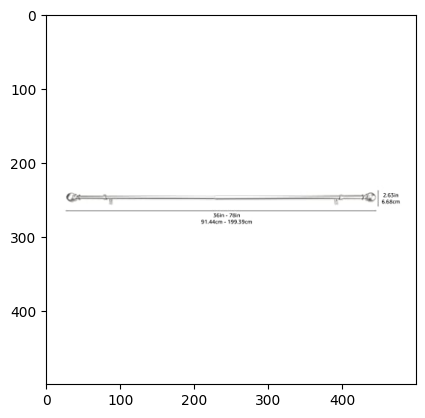

In [31]:
print(entity)
plt.imshow(image)

In [32]:
msgs = [{'role': 'user', 'content': prompt}]

res = model.chat(
    image=image,
    msgs=msgs,
    context=None,
    tokenizer=tokenizer,
    sampling=False
)
print(res)

6.68 cm


In [33]:
results = []
entities = []
for idx, sample in tqdm(inference_data.iterrows(), total=len(inference_data)):
    img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
    entity = sample["entity_name"]
    image, prompt, ocr_text = generate_prompt(img_path, entity)
    msgs = [{'role': 'user', 'content': prompt}]
    res = model.chat(
        image=image,
        msgs=msgs,
        context=None,
        tokenizer=tokenizer,
        sampling=False
    )
    results.append(res)
    entities.append(entity)

  0%|          | 0/95742 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end gene

## post process outputs using entity maps like convert cm to centimeters. Use entity names to find the relevant units and convert the units by matching.
## create submission files from results list

In [34]:
results, entities

(['6.68 cm',
  '42 cm/ 16.54"',
  '200 cm/ 78.74"',
  '200 cm/ 78.74"',
  '4.13 inches',
  '90 cm/ 35.43"',
  '4.13 inches',
  '137.16 cm',
  '40 cm',
  '30 cm'],
 ['height',
  'width',
  'height',
  'depth',
  'depth',
  'height',
  'width',
  'height',
  'width',
  'height'])

In [ ]:
# def generate_post_prompt(result, entity):
#     prompt = f"""You are given the measures of an entity. Modify measure using the correct unit from the provided entity-unit map when needed.
# Example:
# Measure: 2cm
# Entity: item_weight
# Output: 2 centimeter

# Example:
# Measure: 100.0 w
# Entity: wattage
# Output: 100.0 watt

# Example:
# Measure: 10.5gallon
# Entity: item_volume
# Output: 10.5 gallon

# Entity Unit Map:
# - item_weight: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
# - width, depth, height: ['centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard']
# - maximum_weight_recommendation: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
# - voltage: ['kilovolt', 'millivolt', 'volt']
# - wattage: ['kilowatt', 'watt']
# - item_volume: ['centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart']

# Input:
# Measure: {result}
# Entity: {entity}
# Output: """
#     return prompt

In [ ]:
# def generate_answer(prompts, max_length=10):
#     input_ids = post_tokenizer(prompts, return_tensors="pt")
#     input_ids = input_ids["input_ids"].to("cuda:1")
#     outputs = post_model.generate(input_ids, max_new_tokens=max_length)
#     outputs = outputs[:, input_ids.shape[1]:]
#     return post_tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [ ]:
# post_results = []
# for res, ent in tqdm(zip(results, entities), total=len(results)):
#     prompt = generate_post_prompt(res, ent)
#     post_results.append(generate_answer(prompt))

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma-2/transformers/gemma-2-9b/2/")
# model = AutoModelForCausalLM.from_pretrained(
#     "/kaggle/input/gemma-2/transformers/gemma-2-9b/2/",
#     device_map="auto",
#     torch_dtype=torch.bfloat16
# )

In [ ]:
# input_text = "Write me a poem about Machine Learning."
# input_ids = tokenizer(input_text, return_tensors="pt")

# outputs = model.generate(**input_ids, max_length=200)
# print(tokenizer.decode(outputs[0]))

In [ ]:
# input_texts = ["Write me a poem about Machine Learning.",
#                "Write me a poem about Deep Learning.",
#                "Write me a poem about Reinforcement Learning."
#               ]
# input_ids = tokenizer(input_texts, return_tensors="pt")

# outputs = model.generate(**input_ids)
# print(tokenizer.batch_decode(outputs))

In [ ]:
# inference_data["image_text"][3][2:-2], inference_data["entity_name"][3]

In [ ]:
# generate_prompt(inference_data["image_text"][2][2:-2], inference_data["entity_name"][2])

In [ ]:
# generate_answer([generate_prompt(inference_data["image_text"][17][2:-2], inference_data["entity_name"][17])])